### Import packages

In [ ]:
!pip install -q gdown
!pip install -q efficientnet_pytorch
%cd /kaggle/working/

In [6]:
import glob
import math
import random
import sys
import cv2
import numpy as np
import SimpleITK as sitk
from PIL import Image
from scipy import ndimage
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
from PIL import Image

### Generate scribbles

In [7]:
def random_rotation(image, max_angle=15):
    angle = np.random.uniform(-max_angle, max_angle)
    img = Image.fromarray(image)
    img_rotate = img.rotate(angle)
    return img_rotate


def translate_img(img, x_shift, y_shift):

    (height, width) = img.shape[:2]
    matrix = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    trans_img = cv2.warpAffine(img, matrix, (width, height))
    return trans_img


def get_largest_two_component_2D(img, print_info=False, threshold=None):
    """
    Get the largest two components of a binary volume
    inputs:
        img: the input 2D volume
        threshold: a size threshold
    outputs:
        out_img: the output volume 
    """
    s = ndimage.generate_binary_structure(2, 2)  # iterate structure
    labeled_array, numpatches = ndimage.label(img, s)  # labeling
    sizes = ndimage.sum(img, labeled_array, range(1, numpatches+1))
    sizes_list = [sizes[i] for i in range(len(sizes))]
    sizes_list.sort()
    if(print_info):
        print('component size', sizes_list)
    if(len(sizes) == 1):
        out_img = [img]
    else:
        if(threshold):
            max_size1 = sizes_list[-1]
            max_label1 = np.where(sizes == max_size1)[0] + 1
            if max_label1.shape[0] > 1:
                max_label1 = max_label1[0]
            component1 = labeled_array == max_label1
            out_img = [component1]
            for temp_size in sizes_list:
                if(temp_size > threshold):
                    temp_lab = np.where(sizes == temp_size)[0] + 1
                    temp_cmp = labeled_array == temp_lab[0]
                    out_img.append(temp_cmp)
            return out_img
        else:
            max_size1 = sizes_list[-1]
            max_size2 = sizes_list[-2]
            max_label1 = np.where(sizes == max_size1)[0] + 1
            max_label2 = np.where(sizes == max_size2)[0] + 1
            if max_label1.shape[0] > 1:
                max_label1 = max_label1[0]
            if max_label2.shape[0] > 1:
                max_label2 = max_label2[0]
            component1 = labeled_array == max_label1
            component2 = labeled_array == max_label2
            if(max_size2*10 > max_size1):
                out_img = [component1, component2]
            else:
                out_img = [component1]
    return out_img


class Cutting_branch(object):
    def __init__(self):
        self.lst_bifur_pt = 0
        self.branch_state = 0
        self.lst_branch_state = 0
        self.direction2delta = {0: [-1, -1], 1: [-1, 0], 2: [-1, 1], 3: [
            0, -1], 4: [0, 0], 5: [0, 1], 6: [1, -1], 7: [1, 0], 8: [1, 1]}

    def __find_start(self, lab):
        y, x = lab.shape
        idxes = np.asarray(np.nonzero(lab))
        for i in range(idxes.shape[1]):
            pt = tuple([idxes[0, i], idxes[1, i]])
            assert lab[pt] == 1
            directions = []
            for d in range(9):
                if d == 4:
                    continue
                if self.__detect_pt_bifur_state(lab, pt, d):
                    directions.append(d)
            if len(directions) == 1:
                start = pt
                self.start = start
                self.output[start] = 1
                return start
        start = tuple([idxes[0, 0], idxes[1, 0]])
        self.output[start] = 1
        self.start = start
        return start

    def __detect_pt_bifur_state(self, lab, pt, direction):

        d = direction
        y = pt[0] + self.direction2delta[d][0]
        x = pt[1] + self.direction2delta[d][1]
        if lab[y, x] > 0:
            return True
        else:
            return False

    def __detect_neighbor_bifur_state(self, lab, pt):
        directions = []
        for i in range(9):
            if i == 4:
                continue
            if self.output[tuple([pt[0] + self.direction2delta[i][0], pt[1] + self.direction2delta[i][1]])] > 0:
                continue
            if self.__detect_pt_bifur_state(lab, pt, i):
                directions.append(i)

        if len(directions) == 0:
            self.end = pt
            return False
        else:
            direction = random.sample(directions, 1)[0]
            next_pt = tuple([pt[0] + self.direction2delta[direction]
                            [0], pt[1] + self.direction2delta[direction][1]])
            if len(directions) > 1 and pt != self.start:
                self.lst_output = self.output*1
                self.previous_bifurPts.append(pt)
            self.output[next_pt] = 1
            pt = next_pt
            self.__detect_neighbor_bifur_state(lab, pt)

    def __detect_loop_branch(self, end):
        for d in range(9):
            if d == 4:
                continue
            y = end[0] + self.direction2delta[d][0]
            x = end[1] + self.direction2delta[d][1]
            if (y, x) in self.previous_bifurPts:
                self.output = self.lst_output * 1
                return True

    def __call__(self, lab, seg_lab, iterations=1):
        self.previous_bifurPts = []
        self.output = np.zeros_like(lab)
        self.lst_output = np.zeros_like(lab)
        components = get_largest_two_component_2D(lab, threshold=15)
        if len(components) > 1:
            for c in components:
                start = self.__find_start(c)
                self.__detect_neighbor_bifur_state(c, start)
        else:
            c = components[0]
            start = self.__find_start(c)
            self.__detect_neighbor_bifur_state(c, start)
        self.__detect_loop_branch(self.end)
        struct = ndimage.generate_binary_structure(2, 2)
        output = ndimage.morphology.binary_dilation(
            self.output, structure=struct, iterations=iterations)
        shift_y = random.randint(-6, 6)
        shift_x = random.randint(-6, 6)
        if np.sum(seg_lab) > 1000:
            output = translate_img(output.astype(np.uint8), shift_x, shift_y)
            output = random_rotation(output)
        output = output * seg_lab
        return output


def scrible_2d(label, iteration=[4, 10]):
    lab = label
    skeleton_map = np.zeros_like(lab, dtype=np.int32)
    for i in range(lab.shape[0]):
        if np.sum(lab[i]) == 0:
            continue
        struct = ndimage.generate_binary_structure(2, 2)
        if np.sum(lab[i]) > 900 and iteration != 0 and iteration != [0] and iteration != None:
            iter_num = math.ceil(
                iteration[0]+random.random() * (iteration[1]-iteration[0]))
            slic = ndimage.morphology.binary_erosion(
                lab[i], structure=struct, iterations=iter_num)
        else:
            slic = lab[i]
        sk_slice = skeletonize(slic, method='lee')
        sk_slice = np.asarray((sk_slice == True), dtype=np.int32)
        skeleton_map[i] = sk_slice
    return skeleton_map


def scribble4class(label, class_id, class_num, iteration=[4, 10], cut_branch=True):
    label = (label == class_id)
    sk_map = scrible_2d(label, iteration=iteration)
    if cut_branch and class_id != 0:
        cut = Cutting_branch()
        for i in range(sk_map.shape[0]):
            lab = sk_map[i]
            if lab.sum() < 1:
                continue
            sk_map[i] = cut(lab, seg_lab=label[i])
    if class_id == 0:
        class_id = class_num
    return sk_map * class_id


def generate_scribble(label, iterations, cut_branch=True):
    class_num = np.max(label) + 1
    output = np.zeros_like(label, dtype=np.uint8)
    for i in range(class_num):
        it = iterations[i] if isinstance(iterations, list) else iterations
        # if i == 0:
        #     scribble = scribble4class(
        #         label, i, class_num, it, cut_branch=True)
        # else:
        #     scribble = scribble4class(
        #         label, i, class_num, it, cut_branch=True)
        scribble = scribble4class(
                label, i, class_num, it, cut_branch=cut_branch)
        output += scribble.astype(np.uint8)
    return output

(387, 463, 3) (1, 387, 463) (387, 463)


/tmp/ipykernel_584/1776850340.py:176: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  slic = ndimage.morphology.binary_erosion(
/tmp/ipykernel_584/1776850340.py:155: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  output = ndimage.morphology.binary_dilation(


(-0.5, 462.5, 386.5, -0.5)

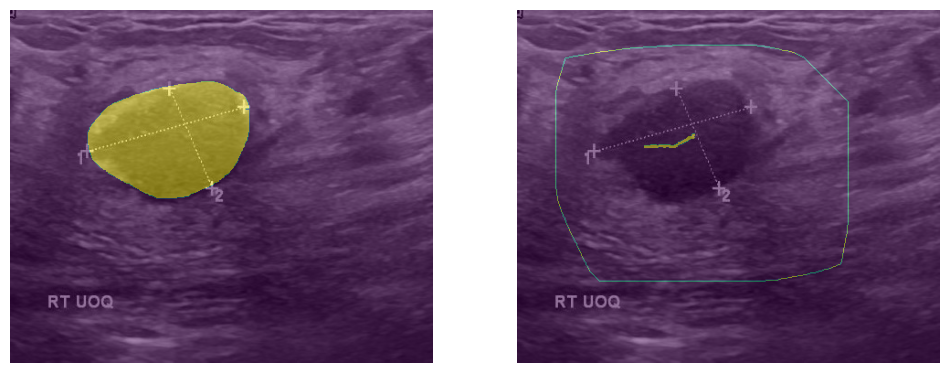

In [8]:
sys.setrecursionlimit(1000000)
seed = 2024
np.random.seed(seed)
random.seed(seed)

image_path = "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (300).png"
label_path= image_path[:-4] + "_mask.png"

image = np.array(Image.open(image_path))

label = np.expand_dims(np.array(Image.open(label_path)).astype(int), axis=0)
scribble = np.squeeze(generate_scribble(label, tuple([1,1]), cut_branch=True))

print(image.shape, label.shape, scribble.shape) ## The scribble have shape [464,591]

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(image)
plt.imshow(label[0], alpha=0.5)
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(image)
plt.imshow(scribble!=0, alpha=0.5)
plt.axis("off")

### Generate edge mask

In [ ]:
%cd /kaggle/working
!git clone https://github.com/ZhouCX117/UAED
!gdown 1nv2_TZRyiQh5oU9TnGMzu313OrspD2l5

In [9]:
%cd /kaggle/working/UAED
class Args:
    def __init__(self):
        self.distribution = None

args = Args()
args.distribution = 'gs'

from model.sigma_logit_unetpp import Mymodel
import torch
edge_detector = Mymodel(in_channels=3, args=args)
checkpoint = torch.load("/kaggle/working/epoch-19-checkpoint.pth")
edge_detector.load_state_dict(checkpoint['state_dict'])
edge_detector.cuda()
edge_detector.eval()

/kaggle/working/UAED


/tmp/ipykernel_584/2479614633.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/kaggle/working/epoch-19-checkpoint.pth")


Mymodel(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 64, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          64, 64, kernel_size=(3, 3), stride=[1, 1], groups=64, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(64, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          64, 16, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          16, 64, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePa

In [10]:
from scipy.ndimage import zoom
from torch.distributions import Normal, Independent
# Assuming 'image' is your input image with shape (473, 554, 3)
x, y, _ = image.shape

# Apply zoom to each channel individually
zoomed_image = zoom(image, (256 / x, 256 / y, 1), order=0)

# Normalize the image to the range [0, 1]
zoomed_image = (zoomed_image - zoomed_image.min()) / (zoomed_image.max() - zoomed_image.min())

x,y = label[0].shape
zoomed_label = zoom(label[0], (256 / x, 256 / y), order=0)

In [11]:
with torch.no_grad():
    image_input = torch.from_numpy(zoomed_image).permute(2,0,1).unsqueeze(0).float().cuda()
    mean, std = edge_detector(image_input)  # Add batch dimension
    _, _, H, W = image_input.shape
    outputs_dist = Independent(Normal(loc=mean, scale=std+0.001), 1)
    outputs = torch.sigmoid(outputs_dist.rsample())
    edge_mask = torch.squeeze(outputs.detach()).cpu().numpy()

In [12]:
edge_mask.shape

(256, 256)

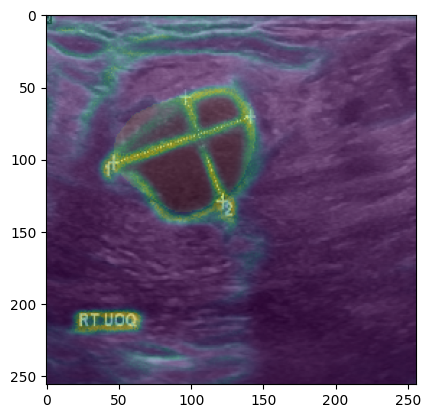

In [13]:
plt.imshow(zoomed_image)
plt.imshow(edge_mask,alpha=0.5)
plt.imshow(zoomed_label, alpha=0.1)

In [ ]:
import torch
import torch.utils.data as data
import numpy as np
from scipy import ndimage
from scipy.ndimage.interpolation import zoom
import random
import os
import h5py
from torch.distributions import Normal, Independent
from PIL import Image

def generate_edge_mask(old_path_data, new_path_data, edge_detector):

    h5_files = os.listdir(old_path_data) ## contains h5 files of training slices

    for h5_file in h5_files:
        h5_file_name = os.path.join(old_path_data, h5_file)
        h5f = h5py.File(h5_file_name, 'r')
        image = h5f['image'][:]

        x,y = image.shape
        image = zoom(image, (256 / x, 256 / y), order=0)
        image = (image - image.min()) / (image.max() - image.min())


        gray_image_tensor = torch.tensor(min_max_image, dtype=torch.float32).unsqueeze(0)
        rgb_image_tensor = torch.cat((gray_image_tensor, gray_image_tensor, gray_image_tensor), dim=0)

        image_input = rgb_image_tensor.unsqueeze(0)
        image_input = image_input.cuda()

        with torch.no_grad():
            mean, std = edge_detector(image_input)  # Add batch dimension
            _,_,H,W = image_input.shape
            outputs_dist=Independent(Normal(loc=mean, scale=std+0.001), 1)
            outputs = torch.sigmoid(outputs_dist.rsample())
            edge_mask=torch.squeeze(outputs.detach()).cpu().numpy()


### Generate Scribble-BUSI with edge mask

In [15]:
import os
import numpy as np
from PIL import Image
from skimage.morphology import skeletonize
from tqdm.auto import tqdm


def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    image_files = [f for f in os.listdir(input_folder) if f.endswith(".png") and not f.endswith("_mask.png")]
    
    for filename in tqdm(image_files, desc=f"Processing {os.path.basename(input_folder)}"):
        image_path = os.path.join(input_folder, filename)
        label_path = image_path[:-4] + "_mask.png"

        if not os.path.exists(label_path):
            print(f"Mask not found for {filename}, skipping.")
            continue

        image = np.array(Image.open(image_path)) ## [height, width]
        label = np.expand_dims(np.array(Image.open(label_path)).astype(int), axis=0) ##[1, height, width]
        scribble = np.squeeze(generate_scribble(label, tuple([1,1]), cut_branch=None)) ##[height, width]

        x, y, _ = image.shape

        # Apply zoom to each channel individually
        zoomed_image = zoom(image, (256 / x, 256 / y, 1), order=0)
        # Normalize the image to the range [0, 1]
        zoomed_image = (zoomed_image - zoomed_image.min()) / (zoomed_image.max() - zoomed_image.min())
        with torch.no_grad():
            image_input = torch.from_numpy(zoomed_image).permute(2,0,1).unsqueeze(0).float().cuda()
            mean, std = edge_detector(image_input)  # Add batch dimension
            _, _, H, W = image_input.shape
            outputs_dist = Independent(Normal(loc=mean, scale=std+0.001), 1)
            outputs = torch.sigmoid(outputs_dist.rsample())
            edge_mask = torch.squeeze(outputs.detach()).cpu().numpy()
        
        # Save image
        Image.fromarray(image).save(os.path.join(output_folder, filename))

        # Save label
        np.save(os.path.join(output_folder, f"{filename[:-4]}_label.npy"), label[0]) ##[height, width]

        # Save scribble
        np.save(os.path.join(output_folder, f"{filename[:-4]}_scribble.npy"), scribble)

        # Save edge mask
        np.save(os.path.join(output_folder, f"{filename[:-4]}_edge.npy"), edge_mask)

# Process both folders
input_folders = [
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign",
    "/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/malignant"
]
output_folder = "/kaggle/working/Scribble_BUSI"

for folder in tqdm(input_folders, desc="Overall progress"):
    process_folder(folder, output_folder)

print("Processing complete. Results saved in", output_folder)

Overall progress:   0%|          | 0/2 [00:00<?, ?it/s]

Processing benign:   0%|          | 0/454 [00:00<?, ?it/s]

/tmp/ipykernel_584/1776850340.py:176: DeprecationWarning: Please import `binary_erosion` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  slic = ndimage.morphology.binary_erosion(


Mask not found for benign (163)_mask_1.png, skipping.
Mask not found for benign (4)_mask_1.png, skipping.
Mask not found for benign (195)_mask_2.png, skipping.
Mask not found for benign (195)_mask_1.png, skipping.
Mask not found for benign (100)_mask_1.png, skipping.
Mask not found for benign (54)_mask_1.png, skipping.
Mask not found for benign (173)_mask_1.png, skipping.
Mask not found for benign (346)_mask_1.png, skipping.
Mask not found for benign (83)_mask_1.png, skipping.
Mask not found for benign (424)_mask_1.png, skipping.
Mask not found for benign (181)_mask_1.png, skipping.
Mask not found for benign (92)_mask_1.png, skipping.
Mask not found for benign (58)_mask_1.png, skipping.
Mask not found for benign (98)_mask_1.png, skipping.
Mask not found for benign (93)_mask_1.png, skipping.
Mask not found for benign (315)_mask_1.png, skipping.
Mask not found for benign (25)_mask_1.png, skipping.


Processing malignant:   0%|          | 0/211 [00:00<?, ?it/s]

Mask not found for malignant (53)_mask_1.png, skipping.
Processing complete. Results saved in /kaggle/working/Scribble_BUSI


In [33]:
!zip -r /kaggle/working/Scribble_BUSI.zip /kaggle/working/Scribble_BUSI

  adding: kaggle/working/Scribble_BUSI/ (stored 0%)
  adding: kaggle/working/Scribble_BUSI/benign (407)_label.npy (deflated 100%)
  adding: kaggle/working/Scribble_BUSI/benign (196).png (deflated 0%)
  adding: kaggle/working/Scribble_BUSI/benign (363)_edge.npy (deflated 8%)
  adding: kaggle/working/Scribble_BUSI/malignant (98)_edge.npy (deflated 8%)
  adding: kaggle/working/Scribble_BUSI/malignant (147)_label.npy (deflated 100%)
  adding: kaggle/working/Scribble_BUSI/benign (196)_label.npy (deflated 100%)
  adding: kaggle/working/Scribble_BUSI/benign (350).png (deflated 0%)
  adding: kaggle/working/Scribble_BUSI/benign (352)_label.npy (deflated 100%)
  adding: kaggle/working/Scribble_BUSI/malignant (53)_edge.npy (deflated 8%)
  adding: kaggle/working/Scribble_BUSI/malignant (154)_scribble.npy (deflated 99%)
  adding: kaggle/working/Scribble_BUSI/benign (394)_label.npy (deflated 100%)
  adding: kaggle/working/Scribble_BUSI/benign (50).png (deflated 0%)
  adding: kaggle/working/Scribble_

In [34]:
!find /kaggle/working/Scribble_BUSI -type f | wc -l

2588
